In [3]:
DATA_PATH = 'data/xlsx/FRS_simulations_with_sex_and_lung_cancer.xlsx'

In [19]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, random_split, DataLoader
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate
import wandb
from tqdm import tqdm
from sklearn.metrics import RocCurveDisplay, roc_auc_score

from src.datasets import LabeledDataset
from src.models import *

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
df = pd.read_excel(DATA_PATH)

In [5]:
inputs = df[df.columns[:-2]].astype(complex).values
inputs = np.stack((
    inputs.real,
    inputs.imag,
    np.abs(inputs),
    np.abs(inputs)
), axis=-1)

In [6]:
ds = TensorDataset(torch.tensor(inputs), torch.tensor(df['Label'].values), torch.tensor(df['sex_numeric'].values))

In [7]:
ds = LabeledDataset(ds, active_label=1)

generator = torch.Generator().manual_seed(42)
splits = random_split(ds, [.8, .1, .1], generator)
ds = {
    'train': splits[0],
    'dev': splits[1],
    'test': splits[2]
}

In [8]:
model = MLPModel([2048, 1024, 512, 256], nn.PReLU).cuda()

In [9]:
training_args = TrainingArguments(
    output_dir='models',
    per_device_train_batch_size=1024,
    per_device_eval_batch_size=1024,
    learning_rate=1e-3,
    warmup_ratio=.1,
    num_train_epochs=100,
    weight_decay=.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    dataloader_pin_memory=True,
    dataloader_num_workers=12,
)

In [10]:
metrics = evaluate.combine(['accuracy', 'precision', 'recall', 'f1'])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return metrics.compute(logits > 0, labels.astype(bool))

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds['dev'],
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(10)
    ]
)

In [12]:
trainer.train()

/home/protossluigi/repos/molecular-fingerprinting/.venv/lib/python3.12/site-packages/torch/nn/parallel/data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: protossluigi to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/protossluigi/repos/molecular-fingerprinting/.venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.693136,0.503750,0.503750,1.000000,0.669992
2,No log,0.693153,0.496250,0.000000,0.000000,0.000000
3,No log,0.692881,0.557750,0.534923,0.934988,0.680513
4,No log,0.677470,0.589250,0.568332,0.767742,0.653156
5,No log,0.643103,0.623750,0.620397,0.652109,0.635858
6,No log,0.803429,0.571000,1.000000,0.148387,0.258427
7,No log,0.474815,0.807500,0.779023,0.862531,0.818653
8,No log,0.433689,0.787750,0.991568,0.583623,0.734770
9,No log,1.682570,0.509000,0.506409,1.000000,0.672339
10,No log,0.487154,0.707750,0.638871,0.965757,0.769018


/home/protossluigi/repos/molecular-fingerprinting/.venv/lib/python3.12/site-packages/torch/nn/parallel/data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
/home/protossluigi/repos/molecular-fingerprinting/.venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/protossluigi/repos/molecular-fingerprinting/.venv/lib/python3.12/site-packages/torch/nn/parallel/data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    t

TrainOutput(global_step=928, training_loss=0.35294116776565027, metrics={'train_runtime': 296.9835, 'train_samples_per_second': 10775.009, 'train_steps_per_second': 5.388, 'total_flos': 0.0, 'train_loss': 0.35294116776565027, 'epoch': 58.0})

In [13]:
trainer.evaluate(ds['test'], metric_key_prefix='test')

/home/protossluigi/repos/molecular-fingerprinting/.venv/lib/python3.12/site-packages/torch/nn/parallel/data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
/home/protossluigi/repos/molecular-fingerprinting/.venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{'test_loss': 0.15352937579154968,
 'test_accuracy': 0.9385,
 'test_precision': 0.9691817215727949,
 'test_recall': 0.9065606361829026,
 'test_f1': 0.9368258859784283,
 'test_runtime': 1.6087,
 'test_samples_per_second': 2486.422,
 'test_steps_per_second': 1.243,
 'epoch': 58.0}

In [14]:
wandb.finish()

eval/accuracy,▁▁▂▂▃▆▆▁▄▁▆▄▇▇▇▇▇▇█▇▇▇▆█▆▇█▇████████▇▇██
eval/f1,▆▁▆▆▆▇▆▆▆▇▇██▇█▇█▇██▇██▇████████████████
eval/loss,▃▃▃▃▃▂▂▆▂█▂▁▂▁▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▅▅█▆▅▅▅▅▆▅█▇█▇█▇█▇▇▆▆█▆█▇▇███████▇███▇█
eval/recall,█▁█▆▂▅█████▇▆▇███▆▇▆█▇██▇▇▇█▇▇▇▇▇▇█▇▆▇█▇
eval/runtime,▁▄▅▄▄▅█▅▃▅▄▅▆▃▄▇▄▆▄▇▅▅▆▆▄▆▅▂▅▃▄▆▂▅▆▆▇▄▆▄
eval/samples_per_second,▇█▄▄▄▅▄▁▄▃▅▃▄▆▅▂▅▅▂▄▄▃▃▅▃▆▇▄▅▅▃▄▇▄▃▃▂▅▃▄
eval/steps_per_second,▇█▅▅▅▅▃▅▄▆▁▆▄▅▅▇▆▄▃▆▅▅▅▄▅▇▅▆▄▅▄▅▇▅▄▄▄▃▅▅
test/accuracy,▁
test/f1,▁
test/loss,▁


In [15]:
dl = DataLoader(ds['test'], batch_size=1024, shuffle=False, pin_memory=True)

In [16]:
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(dl, desc='Evaluating'):
        y_true.append(batch['labels'])
        X_batch = batch['inputs'].to(device)
        logits = model(X_batch)['logits']
        y_pred.append(nn.functional.sigmoid(logits).cpu())

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 10.98it/s]


In [17]:
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc}")

AUC: 0.98469919917117


[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'Classification ROC')]

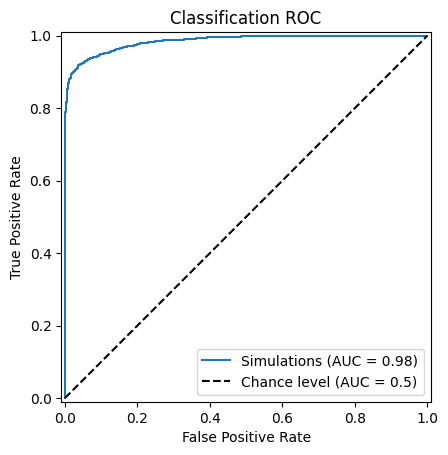

In [18]:
display = RocCurveDisplay.from_predictions(
    y_true,
    y_pred,
    name=f"Simulations",
    plot_chance_level=True,
    # despine=True,
)
display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Classification ROC",
)